<img src="https://github.com/nicholasmetherall/digital-earth-pacific-macblue-activities/blob/main/attachments/images/DE_Pacific_banner.JPG?raw=true" width="900"/>
Figure 1.1.a. Jupyter environment + Python notebooks

### Digital Earth Pacific Notebook 1 prepare postcard and load data to csv

The objective of this notebook is to prepare a geomad postcard for your AOI (masking, scaling and loading additional band ratios and spectral indices) and sampling all the datasets into a csv based on your training data geodataframe.

Step 1.1

In [1]:
# Predefined variable for title and version
version = "random_forest_26042025"  # Replace this with the variable you want to use

In [2]:
from pystac_client import Client
from dask.distributed import Client as DaskClient
from odc.stac import load, configure_s3_access
import rasterio as rio
import geopandas as gpd
import pandas as pd
import numpy as np
import xarray as xr
import folium
import utils
# from utils import apply_masks
from utils import scale
from utils import calculate_band_indices
from utils import load_data
# from utils import mask_deeps_stumpf
# from utils import mask_deeps_ln_bg
# from utils import mask_deeps
# from utils import do_prediction 
# from utils import mask_and_scale
from sklearn.ensemble import RandomForestClassifier
import odc.geo.xr
import rioxarray
import matplotlib.pyplot as plt
import joblib
from shapely.geometry import box

Define catalogue

In [3]:
catalog = "https://stac.digitalearthpacific.org"
client = Client.open(catalog)

In [4]:
gdf = gpd.read_file("training-data/bootless_bay.geojson")
gdf = gdf.to_crs("EPSG:4326")
min_lon, min_lat, max_lon, max_lat = gdf.total_bounds
bbox = [min_lon, min_lat, max_lon, max_lat]

In [5]:
# min_lon = 177.415519953916
# min_lat = -17.61336539049535
# max_lon = 177.46341277889703
# max_lat = -17.576247293553328

# bbox = [min_lon, min_lat, max_lon, max_lat]

In [6]:
datetime="2024"
items = list(client.search(collections=["dep_s2_geomad"], datetime=datetime, bbox=bbox).items())

In [7]:
from pystac import Collection

In [8]:
collection = Collection.from_file("https://stac.digitalearthpacific.org/collections/dep_s2_geomad")

In [9]:
data = load(
        items,
        measurements=[
            "nir", "red", "blue", "green", "emad", "smad", 
            "bcmad", "count", "green", "nir08", 
            "nir09", "swir16", "swir22", "coastal",
            "rededge1", "rededge2", "rededge3", 
        ],
        bbox=bbox,
        chunks={"x": 2048, "y": 2048},
        groupby="solar_day",
    )

In [10]:
# dask_client = DaskClient(n_workers=1, threads_per_worker=16, memory_limit='16GB')
# configure_s3_access(cloud_defaults=True, requester_pays=True)

In [11]:
scaled = (data.where(data != 0) * 0.0001).clip(0, 1)

In [12]:
mndwi = (scaled["green"]-scaled["swir16"])/(scaled["green"]+scaled["swir16"])
mndwi_land_mask = mndwi > 0
clipped_ds = scaled.where(mndwi_land_mask)

In [13]:
ndti = (clipped_ds["red"]-clipped_ds["green"])/(clipped_ds["red"]+clipped_ds["green"])
ndti_mask = ndti < 0.2
clipped_ds = clipped_ds.where(ndti_mask)

In [14]:
nir = clipped_ds['nir']
nir_mask = nir < 0.085
clipped_ds = clipped_ds.where(nir_mask)

In [15]:
# Incorporate other band ratios and indices
cai = (clipped_ds["coastal"]-clipped_ds["blue"])/( clipped_ds["coastal"]+ clipped_ds["blue"]) #coastal aerosol index
ndvi = (clipped_ds["nir"]-clipped_ds["red"])/( clipped_ds["nir"]+ clipped_ds["red"]) #vegetation index (NDVI)
ndwi = (clipped_ds["green"]-clipped_ds["nir"])/(clipped_ds["green"]+clipped_ds["nir"]) #water index (NDWI)
b_g = (clipped_ds["blue"])/(clipped_ds["green"]) #blue to green ratio
b_r = (clipped_ds["blue"])/(clipped_ds["red"]) #blue to red ratio
mci = (clipped_ds["nir"])/(clipped_ds["rededge1"]) # max chlorophlyll index (MCI)
ndci = (clipped_ds["rededge1"]-clipped_ds["red"])/(clipped_ds["rededge1"]+clipped_ds["red"]) # normalised difference chlorophyll index (NDCI)


In [16]:
clipped_ds['cai'] = cai
clipped_ds['ndvi'] = ndvi
clipped_ds['ndwi'] = ndwi
clipped_ds['mndwi'] = mndwi
clipped_ds['ndti'] = ndti
clipped_ds['b_g'] = b_g
clipped_ds['b_r'] = b_r
clipped_ds['mci'] = mci
clipped_ds['ndci'] = ndci

# clipped_ds

In [17]:
# Natural log of blue/green
clipped_ds["ln_bg"] = np.log(clipped_ds.blue / clipped_ds.green)
bg = clipped_ds["ln_bg"]
mask_bg = bg > 0.2

In [18]:
# add an epsilon 
epsilon = 1e-6

# additional indices from SDB (Alex)*

# Calculate the stumpf index safely
clipped_ds['stumpf'] = np.log(np.abs(clipped_ds.green - clipped_ds.blue)) / np.log(
    clipped_ds.green + clipped_ds.blue + epsilon
)

# Define stumpf as a variable
stumpf = clipped_ds['stumpf']

# Mask out infinite or near-infinite values
stumpf_cleaned = stumpf.where(np.isfinite(stumpf))  # Keeps only finite values

# Optionally, remove very large values (e.g., threshold at 2.0)
stumpf_cleaned = stumpf_cleaned.where(stumpf_cleaned < 100.0)

# Replace the cleaned stumpf index back in the dataset
clipped_ds['stumpf'] = stumpf_cleaned

# Define mask
stumpf = clipped_ds['stumpf']
mask_stumpf = stumpf < 2.0


In [19]:
all_masks = (mndwi_land_mask+ndti_mask+nir_mask+mask_bg+mask_stumpf)

In [20]:


# df = pd.DataFrame(
#     stacked_arrays.values.T,  # Transpose so each row corresponds to an observation
#     columns=stacked_arrays.coords['variable'].values  # Use band names as column labels
# )


In [21]:
# # Remove the all-zero rows
# # zero_mask = (df == 0).all(axis=1)  # Creates a boolean Series
# # non_zero_df = df.loc[~zero_mask]  # Filters out all-zero rows
# zero_mask = (df == 0).all(axis=1)  # Creates a boolean Series
# non_zero_df = df.loc[~zero_mask]  # Filters out all-zero rows


# # Create a new array to hold the predictions
# full_pred = pd.Series(np.nan, index=df.index)

# # # Predict the classes
# # predicted = model.predict(stacked_arrays)

# # # Reshape back to the original 2D array
# # array = predicted.reshape(ds.y.size, ds.x.size)

# # # Convert to an xarray again, because it's easier to work with
# # predicted_da = xr.DataArray(array, coords={"y": ds.y, "x": ds.x}, dims=["y", "x"])



### Postcard csv

The objective of this notebook was to train the machine learning model that will allow us to classify an area with land cover classes defined through the training data.

Step 1.2. Input the training data to sample geomad data from the postcard

In [22]:
# Define training data
gdf = gpd.read_file("training-data/bootless_bay.geojson")
gdf = gdf.to_crs("EPSG:4326")
# gdf.explore(column="cc_id", legend=True)

In [23]:
postcard = clipped_ds#.where(all_masks)
# postcard =clipped_ds.to_array(dim="band")
# First transform the training points to the same CRS as the data
training = gdf.to_crs(postcard.odc.geobox.crs)

In [24]:
print(training.columns)
training=training.drop(columns=['date', 'uuid'])

Index(['uuid', 'cc_id', 'observed', 'date', 'geometry'], dtype='object')


In [25]:
training

,cc_id,observed,geometry
0,4,seagrass,POINT (-302092.206 -1057912.4)
1,4,seagrass,POINT (-302078.83 -1057913.449)
2,4,seagrass,POINT (-302078.478 -1057944.572)
3,4,seagrass,POINT (-302089.39 -1057922.891)
4,4,seagrass,POINT (-302062.638 -1057910.301)
...,...,...,...
815,10,land,POINT (-303113.729 -1059579.147)
816,10,land,POINT (-303119.481 -1059533.436)
817,10,land,POINT (-303119.481 -1059484.296)
818,10,land,POINT (-303136.735 -1059439.728)


In [26]:
training_da = training.assign(x=training.geometry.x, y=training.geometry.y).to_xarray()

In [27]:
training_values = (
    postcard.sel(training_da[["x", "y"]], method="nearest").squeeze().compute().to_pandas()
)
training_values

/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))


,nir,red,blue,green,emad,smad,bcmad,count,nir08,nir09,...,ndvi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci,ln_bg,stumpf
index,,,,,,,,,,,,,,,,,,,,,
0,0.0602,0.0742,0.0926,0.1005,0.152102,0.000002,0.000034,0.0031,0.0637,0.0988,...,-0.104167,0.250778,0.248447,-0.150544,0.921393,1.247978,0.806971,0.002688,-0.081869,2.943612
1,0.0598,0.0750,0.0989,0.1071,0.161220,0.000003,0.000034,0.0031,0.0648,0.0689,...,-0.112760,0.283403,0.277281,-0.176277,0.923436,1.318667,0.801609,-0.002674,-0.079654,3.040509
2,0.0597,0.0750,0.0949,0.1040,0.161838,0.000003,0.000034,0.0031,0.0667,0.0682,...,-0.113586,0.270617,0.254524,-0.162011,0.912500,1.265333,0.777344,0.011858,-0.091567,2.909989
3,0.0597,0.0752,0.0952,0.1040,0.158307,0.000002,0.000034,0.0031,0.0662,0.0687,...,-0.114900,0.270617,0.259843,-0.160714,0.915385,1.265957,0.790728,0.001991,-0.088411,2.933484
4,0.0580,0.0723,0.0995,0.1074,0.159002,0.000003,0.000034,0.0031,0.0638,0.0677,...,-0.109747,0.298670,0.286998,-0.195326,0.926443,1.376210,0.818054,-0.009776,-0.076403,3.072578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
815,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.524204,NaN,NaN,NaN,NaN,NaN,NaN,NaN
816,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.501202,NaN,NaN,NaN,NaN,NaN,NaN,NaN
817,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,-0.502588,NaN,NaN,NaN,NaN,NaN,NaN,NaN


/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.10/site-packages/dask/core.py:127: RuntimeWarning: divide by zero encountered in log
  return func(*(_execute_task(a, cache) for a in args))
/srv/conda/envs/notebook/lib/python3.10/site-packages/rasterio/warp.py:387: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dest = _reproject(


In [28]:
# Join the training data with the extracted values and remove unnecessary columns
training_array = pd.concat([training["cc_id"], training_values], axis=1)
# Drop rows where there was no data available
training_array = training_array.dropna()
# Preview our resulting training array
training_array.head()

,cc_id,nir,red,blue,green,emad,smad,bcmad,count,nir08,...,ndvi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci,ln_bg,stumpf
0,4,0.0602,0.0742,0.0926,0.1005,0.152102,0.000002,0.000034,0.0031,0.0637,...,-0.104167,0.250778,0.248447,-0.150544,0.921393,1.247978,0.806971,0.002688,-0.081869,2.943612
1,4,0.0598,0.0750,0.0989,0.1071,0.161220,0.000003,0.000034,0.0031,0.0648,...,-0.112760,0.283403,0.277281,-0.176277,0.923436,1.318667,0.801609,-0.002674,-0.079654,3.040509
2,4,0.0597,0.0750,0.0949,0.1040,0.161838,0.000003,0.000034,0.0031,0.0667,...,-0.113586,0.270617,0.254524,-0.162011,0.912500,1.265333,0.777344,0.011858,-0.091567,2.909989
3,4,0.0597,0.0752,0.0952,0.1040,0.158307,0.000002,0.000034,0.0031,0.0662,...,-0.114900,0.270617,0.259843,-0.160714,0.915385,1.265957,0.790728,0.001991,-0.088411,2.933484
4,4,0.0580,0.0723,0.0995,0.1074,0.159002,0.000003,0.000034,0.0031,0.0638,...,-0.109747,0.298670,0.286998,-0.195326,0.926443,1.376210,0.818054,-0.009776,-0.076403,3.072578


### Notebook 2 - Train Random Forest Machine Learning (ML) Model

Combine the csv geodataframes from notebook 1 into a single csv to train the machine learning model

Step 2.1. Concatenating all postcard dataframes

In [30]:
# Data cleaning

# mask_r = clipped_ds.red.isnull()  # Probably should check more bands


# # Convert to a stacked array of observations
# stacked_arrays = clipped_ds.to_array().stack(dims=["y", "x"])

# # Replace any infinities with NaN
# stacked_arrays = stacked_arrays.where(stacked_arrays != float("inf"))
# stacked_arrays = stacked_arrays.where(stacked_arrays != float("-inf"))

# # Replace any NaN values with 0
# # TODO: Make sure that each column is labelled with the correct band name
# stacked_arrays = stacked_arrays.squeeze().fillna(0).transpose()


# # Flatten the stacked array (if not already flattened)
# data_values = stacked_arrays.values  # Shape: (27, 230688)

# # Ensure the number of features matches the column names
# column_names = list(stacked_arrays.coords['variable'].values)  # Length: 27

# # Transpose only if the data's shape does not match the expected DataFrame structure
# # Each row should correspond to an observation, and each column to a feature
# if data_values.shape[0] == len(column_names):
#     # Correct format: rows = observations, columns = features
#     data_values = data_values.T  # Shape: (230688, 27)

# # Create DataFrame
# df = pd.DataFrame(data_values, columns=column_names)

# # Remove all-zero rows
# zero_mask = (df == 0).all(axis=1)
# non_zero_df = df.loc[~zero_mask]

# # Create a new array to hold predictions (if needed)
# full_pred = pd.Series(np.nan, index=non_zero_df.index)

# # Continue with your prediction logic if a model is defined
# # predicted = model.predict(non_zero_df)

In [31]:
# # Data cleaning
# mask_r = clipped_ds.red.isnull()  # Probably should check more bands

# # Convert to a stacked array of observations
# stacked_arrays = clipped_ds.to_array().stack(dims=["y", "x"])

# # Replace any infinities with NaN
# stacked_arrays = stacked_arrays.where(stacked_arrays != float("inf"))
# stacked_arrays = stacked_arrays.where(stacked_arrays != float("-inf"))

# # Replace any NaN values with 0
# # TODO: Make sure that each column is labelled with the correct band name
# stacked_arrays = stacked_arrays.squeeze().fillna(0).transpose()


# # Flatten the stacked array (if not already flattened)
# data_values = stacked_arrays.values  # Shape: (27, 230688)

# # Ensure the number of features matches the column names
# column_names = list(stacked_arrays.coords['variable'].values)  # Length: 27

# # Transpose only if the data's shape does not match the expected DataFrame structure
# # Each row should correspond to an observation, and each column to a feature
# if data_values.shape[0] == len(column_names):
#     # Correct format: rows = observations, columns = features
#     data_values = data_values.T  # Shape: (230688, 27)

# # Create DataFrame
# df = pd.DataFrame(data_values, columns=column_names)

# # Remove all-zero rows
# zero_mask = (df == 0).all(axis=1)
# non_zero_df = df.loc[~zero_mask]

# # Create a new array to hold predictions (if needed)
# full_pred = pd.Series(np.nan, index=non_zero_df.index)

# # Continue with your prediction logic if a model is defined
# # predicted = model.predict(non_zero_df)

In [32]:
# postcard_df = gpd.read_file("training-data/joined_training_data_11042025_test.csv")
# postcard_df

In [33]:
# postcard_df.columns


In [34]:
postcard_df = training_array
postcard_df.columns

Index(['cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad',
       'count', 'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1',
       'rededge2', 'rededge3', 'y', 'x', 'spatial_ref', 'time', 'cai', 'ndvi',
       'ndwi', 'mndwi', 'ndti', 'b_g', 'b_r', 'mci', 'ndci', 'ln_bg',
       'stumpf'],
      dtype='object')

In [35]:
postcard_df.columns

Index(['cc_id', 'nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad',
       'count', 'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1',
       'rededge2', 'rededge3', 'y', 'x', 'spatial_ref', 'time', 'cai', 'ndvi',
       'ndwi', 'mndwi', 'ndti', 'b_g', 'b_r', 'mci', 'ndci', 'ln_bg',
       'stumpf'],
      dtype='object')

In [36]:
# postcard_df.columns
# postcard_df = postcard_df.drop(columns=["spatial_ref", "time", "field_1", "y", "x"])
# postcard_df = postcard_df.drop(columns=["field_1"])
postcard_df = postcard_df.drop(columns=["y", "x", "spatial_ref"])
postcard_df = postcard_df.drop(columns=["time"])
postcard_df

,cc_id,nir,red,blue,green,emad,smad,bcmad,count,nir08,...,ndvi,ndwi,mndwi,ndti,b_g,b_r,mci,ndci,ln_bg,stumpf
0,4,0.0602,0.0742,0.0926,0.1005,0.152102,0.000002,0.000034,0.0031,0.0637,...,-0.104167,0.250778,0.248447,-0.150544,0.921393,1.247978,0.806971,0.002688,-0.081869,2.943612
1,4,0.0598,0.0750,0.0989,0.1071,0.161220,0.000003,0.000034,0.0031,0.0648,...,-0.112760,0.283403,0.277281,-0.176277,0.923436,1.318667,0.801609,-0.002674,-0.079654,3.040509
2,4,0.0597,0.0750,0.0949,0.1040,0.161838,0.000003,0.000034,0.0031,0.0667,...,-0.113586,0.270617,0.254524,-0.162011,0.912500,1.265333,0.777344,0.011858,-0.091567,2.909989
3,4,0.0597,0.0752,0.0952,0.1040,0.158307,0.000002,0.000034,0.0031,0.0662,...,-0.114900,0.270617,0.259843,-0.160714,0.915385,1.265957,0.790728,0.001991,-0.088411,2.933484
4,4,0.0580,0.0723,0.0995,0.1074,0.159002,0.000003,0.000034,0.0031,0.0638,...,-0.109747,0.298670,0.286998,-0.195326,0.926443,1.376210,0.818054,-0.009776,-0.076403,3.072578
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,2,0.0658,0.1405,0.1520,0.1848,0.134837,0.000003,0.000026,0.0025,0.0566,...,-0.362094,0.474860,0.634675,-0.136182,0.822511,1.081851,0.541118,-0.072110,-0.195394,3.140166
803,2,0.0449,0.0928,0.1084,0.1283,0.105597,0.000002,0.000024,0.0025,0.0417,...,-0.347858,0.481524,0.559878,-0.160561,0.844895,1.168103,0.593915,-0.102138,-0.168543,2.718356
804,2,0.0431,0.0950,0.1181,0.1391,0.111688,0.000003,0.000020,0.0025,0.0437,...,-0.375815,0.526894,0.571751,-0.188381,0.849029,1.243158,0.498266,-0.046832,-0.163661,2.845011
805,2,0.0487,0.1173,0.1420,0.1701,0.115321,0.000002,0.000021,0.0025,0.0433,...,-0.413253,0.554845,0.636364,-0.183716,0.834803,1.210571,0.563006,-0.151129,-0.180559,3.067587


In [37]:
len(postcard_df.columns)

28

Step 2.2. Train the ML model

In [38]:
# # The classes are the first column
# classes = np.array(postcard_df)[:, 0]

# # The observation data is everything after the second column
# observations = np.array(postcard_df)[:, 1:]

# # Create a model...
# classifier = RandomForestClassifier()

# # ...and fit it to the data
# model = classifier.fit(observations, classes)

In [39]:
# The classes are the first column
classes = np.array(postcard_df)[:, 0]

# The observation data is everything after the second column
observations = np.array(postcard_df)[:, 1:]

# Create a model...
classifier = RandomForestClassifier()

# ...and fit it to the data
model = classifier.fit(observations, classes)

In [40]:
# Dynamically create the filename with f-string
file_path = f"models/{version}-test.model"

# Save the model
joblib.dump(model, file_path)

['models/random_forest_26042025-test.model']

In [41]:
postcard_params = postcard_df.columns[1:]
print(postcard_params)

Index(['nir', 'red', 'blue', 'green', 'emad', 'smad', 'bcmad', 'count',
       'nir08', 'nir09', 'swir16', 'swir22', 'coastal', 'rededge1', 'rededge2',
       'rededge3', 'cai', 'ndvi', 'ndwi', 'mndwi', 'ndti', 'b_g', 'b_r', 'mci',
       'ndci', 'ln_bg', 'stumpf'],
      dtype='object')


In [42]:
importances = classifier.feature_importances_

# Create the DataFrame
data = {
    'param': postcard_params,  # Use the list directly
    'importance': importances,  # Use the list directly
}
importance_df = pd.DataFrame(data)

importance_df
importance_df.to_csv(f"{version}importance_df.csv")

In [43]:
importance_df

,param,importance
0,nir,0.010365
1,red,0.063374
2,blue,0.024716
3,green,0.088498
4,emad,0.008628
5,smad,0.009692
6,bcmad,0.007290
7,count,0.017943
8,nir08,0.015829
9,nir09,0.019200


In [44]:
postcard


<xarray.Dataset> Size: 14MB
Dimensions:      (time: 1, y: 490, x: 262)
Coordinates:
  * y            (y) float64 4kB -1.055e+06 -1.055e+06 ... -1.06e+06 -1.06e+06
  * x            (x) float64 2kB -3.036e+05 -3.036e+05 ... -3.01e+05 -3.01e+05
    spatial_ref  int32 4B 3832
  * time         (time) datetime64[ns] 8B 2024-01-01
Data variables: (12/27)
    nir          (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    red          (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    blue         (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    green        (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    emad         (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    smad         (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    ...           ...
    b_g          (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    b_r          (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    mci          (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    ndci         (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    ln_bg        (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>
    stumpf       (time, y, x) float32 514kB dask.array<chunksize=(1, 490, 262), meta=np.ndarray>

In [45]:
# Convert to a stacked array of observations
# stacked_arrays = stacked_arrays.squeeze()
stacked_arrays = postcard.squeeze()#.stack(dims=["y", "x"])#.transpose()
stacked_arrays = stacked_arrays.to_dataarray()

In [46]:
# # Convert to a stacked array of observations
# # stacked_arrays = stacked_arrays.squeeze()
# stacked_arrays = postcard.squeeze().stack(dims=["y", "x"]).transpose()
# stacked_arrays = stacked_arrays.to_dataarray()

In [47]:
stacked_arrays

<xarray.DataArray (variable: 27, y: 490, x: 262)> Size: 14MB
dask.array<stack, shape=(27, 490, 262), dtype=float32, chunksize=(1, 490, 262), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 4kB -1.055e+06 -1.055e+06 ... -1.06e+06 -1.06e+06
  * x            (x) float64 2kB -3.036e+05 -3.036e+05 ... -3.01e+05 -3.01e+05
    spatial_ref  int32 4B 3832
    time         datetime64[ns] 8B 2024-01-01
  * variable     (variable) object 216B 'nir' 'red' 'blue' ... 'ln_bg' 'stumpf'

In [48]:
# stacked_arrays_2d

In [49]:
stacked_arrays_2d = stacked_arrays.stack(new_dim=("y", "x")) 

In [50]:
reordered_data_array = stacked_arrays_2d.transpose('new_dim', 'variable')

In [51]:
# stacked_arrays = stacked_arrays.reshape(-1, 26)
stacked_arrays_2d.shape


(27, 128380)

In [52]:
# Convert to a stacked array of observations
# stacked_arrays_2d = stacked_arrays_2d.to_array().stack(dims=["y", "x"])

# Replace any infinities with NaN
stacked_arrays_2d = stacked_arrays_2d.where(stacked_arrays_2d != float("inf"))
stacked_arrays_2d = stacked_arrays_2d.where(stacked_arrays_2d != float("-inf"))

# Replace any NaN values with 0
df = stacked_arrays_2d.squeeze().fillna(0).transpose().to_pandas()

# Remove the all-zero rows
zero_mask = (df == 0).all(axis=1)  # Creates a boolean Series
non_zero_df = df.loc[~zero_mask]  # Filters out all-zero rows

# Create a new array to hold the predictions
full_pred = pd.Series(np.nan, index=df.index)

reordered_data_array = stacked_arrays_2d.transpose('new_dim', 'variable')

In [53]:
# Predict the classes

predicted = model.predict(reordered_data_array)


In [54]:

# Reshape back to the original 2D array
reordered_data_array = predicted.reshape(len(postcard.y), len(postcard.x))

# Convert to an xarray again, because it's easier to work with
predicted_da = xr.DataArray(
    reordered_data_array, coords={"y": postcard.y, "x": postcard.x}, dims=["y", "x"]
)

In [55]:
print(predicted_da.dtype)  # Check the dtype of your DataArray
predicted_da = predicted_da.astype('float32')  # Convert to float32

# Check for NaN values
if np.isnan(predicted_da).any():
    print("NaN values found in the data")
    # Handle NaN values, e.g. by filling them
    predicted_da = predicted_da.fillna(0)  # Replace NaN with 0 or appropriate value

float64


In [56]:
predicted_da

<xarray.DataArray (y: 490, x: 262)> Size: 514kB
array([[8., 8., 8., ..., 8., 8., 8.],
       [8., 8., 8., ..., 8., 8., 8.],
       [8., 8., 8., ..., 8., 8., 8.],
       ...,
       [8., 8., 8., ..., 8., 8., 8.],
       [8., 8., 8., ..., 8., 8., 8.],
       [8., 8., 8., ..., 8., 8., 8.]], dtype=float32)
Coordinates:
  * y        (y) float64 4kB -1.055e+06 -1.055e+06 ... -1.06e+06 -1.06e+06
  * x        (x) float64 2kB -3.036e+05 -3.036e+05 ... -3.01e+05 -3.01e+05

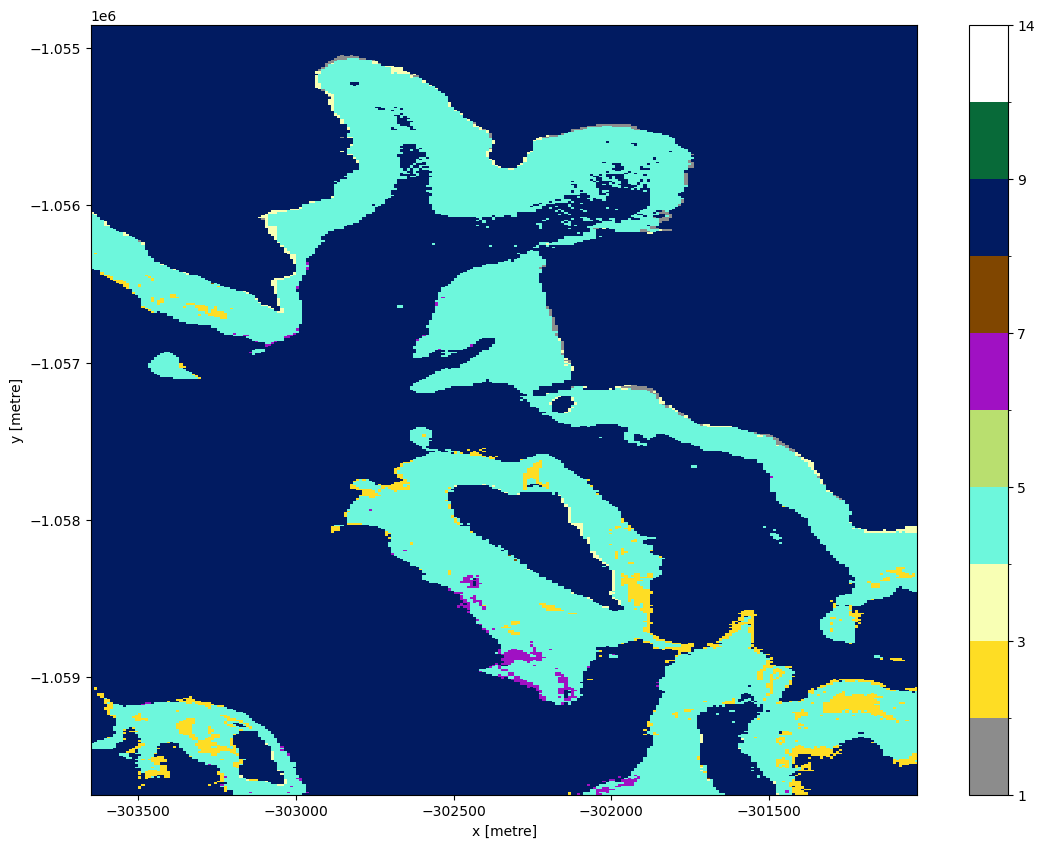

In [57]:
from matplotlib import colors

classes = [
    [1, "sediment", "#8c8c8c"],
    [2, "sand", "#fedd24"],
    [3, "rubble", "#f8ffb4"],
    [4, "seagrass", "#6df7dc"],
    [5, "seaweed", "#b9df6f"],
    [6, "coral", "#a011c3"],
    [7, "rock", "#804600"],
    [8, "deeps", "#011b61"],
    [9, "mangrove", "#086a39"],
    [10, "land", "#ffffff"],
]

values_list = [c[0] for c in classes]
color_list = [c[2] for c in classes]

# Build a listed colormap.
c_map = colors.ListedColormap(color_list)
bounds = values_list + [14]
norm = colors.BoundaryNorm(bounds, c_map.N)

predicted_da.plot.imshow(cmap=c_map, norm=norm, size=10)

In [58]:
predicted_da.odc.explore()

In [59]:
# issue where not all masks are being included - only land but not surf / also strange effect on side
predicted_da = predicted_da.where(bg < 0.2)
predicted_da.odc.explore(cmap=c_map)

In [60]:
# issue where not all masks are being included - only land but not surf / also strange effect on side
predicted_da = predicted_da.where(all_masks)
predicted_da.odc.explore(cmap=c_map)

In [61]:
# issue where not all masks are being included - only land but not surf / also strange effect on side
predicted_da = predicted_da.where(all_masks)

In [62]:
predicted_da.odc.explore(cmap=c_map)

In [151]:
predicted_da.odc.write_cog(f"{version}.tiff", overwrite=True)

PosixPath('random_forest_26042025.tiff')